In [114]:
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import timedelta
%matplotlib inline

In [2]:
# read excel file
df_asli = pd.read_excel('./data/kemayoran 2000-2022.xlsx')

In [4]:
# hasil excel
df_asli.info

<bound method DataFrame.info of          Tanggal      RR
0     01-01-2000     9.1
1     02-01-2000  8888.0
2     03-01-2000  8888.0
3     04-01-2000    50.2
4     05-01-2000     1.6
...          ...     ...
8151  26-04-2022    26.4
8152  27-04-2022  8888.0
8153  28-04-2022     7.5
8154  29-04-2022  8888.0
8155  30-04-2022     0.0

[8156 rows x 2 columns]>

In [14]:
# max value RR Data Asli
max_value = df_asli['RR']
max_value.max()

8888.0

In [15]:
# menyalin data asli ke data training
train = df_asli
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8156 entries, 0 to 8155
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Tanggal  8156 non-null   datetime64[ns]
 1   RR       7883 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 127.6 KB


In [16]:
# mengubah format tanggal dari object ke datetime
train['Tanggal'] = pd.to_datetime(train['Tanggal'], format="%d-%m-%Y")
train.tail()

,Tanggal,RR
8151,2022-04-26,26.4
8152,2022-04-27,8888.0
8153,2022-04-28,7.5
8154,2022-04-29,8888.0
8155,2022-04-30,0.0


In [17]:
# check nilai null
# jumlah null value train
train.isnull().sum()

Tanggal      0
RR         273
dtype: int64

In [18]:
# replace NaN ke 0
df_predict_clean = train.fillna(0)
# cek NaN di df baru
df_predict_clean.isnull().sum()

Tanggal    0
RR         0
dtype: int64

In [34]:
# replace abnormal value > 100
cond_1 = df_predict_clean.loc[df_predict_clean['RR'] > 100, 'RR']
# cari maksimal value dalam dataframe df_predict_clean, selain diatas 500 (sudah abnormal)
cond_1.loc[cond_1 < 500].max()

277.5

In [61]:
# mengganti abnormal value ke 277.5 di df_predict_clean
df_predict_clean.loc[df_predict_clean['RR'] > 500, 'RR'] = 277.5
df_predict_clean['RR'].max()

277.5

In [62]:
# pindah data clean ke train_df Dataframe
train_df = df_predict_clean
train_df.head()

,Tanggal,RR
0,2000-01-01,9.1
1,2000-01-02,277.5
2,2000-01-03,277.5
3,2000-01-04,50.2
4,2000-01-05,1.6


In [63]:
train_df['Tanggal']

0      2000-01-01
1      2000-01-02
2      2000-01-03
3      2000-01-04
4      2000-01-05
          ...    
8151   2022-04-26
8152   2022-04-27
8153   2022-04-28
8154   2022-04-29
8155   2022-04-30
Name: Tanggal, Length: 8156, dtype: datetime64[ns]

<AxesSubplot:xlabel='Tanggal', ylabel='RR'>

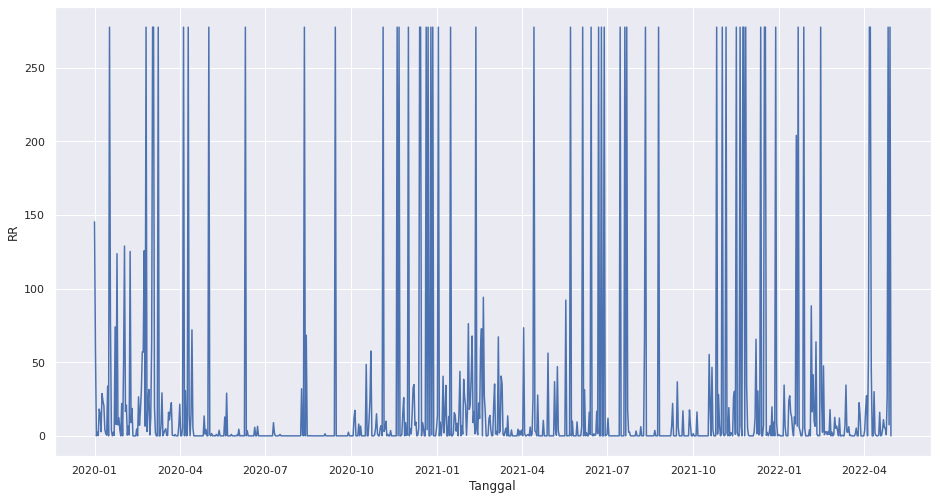

In [64]:
# plotting tahun 2020
# untuk mengganti, ganti df_rain_20 ke train_df dan hapus df_rain_20 dibawah ini
df_rain_20 = train_df[train_df['Tanggal'] > '2019-12-31']
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(x="Tanggal", y="RR",legend='full' ,data=df_rain_20)

# Identifikasi Data

In [65]:
# set_index df_rain_20
df_rain_20 = df_rain_20.set_index('Tanggal')
df_rain_20.head()

,RR
Tanggal,
2020-01-01,145.3
2020-01-02,58.8
2020-01-03,0.0
2020-01-04,2.5
2020-01-05,0.2


<Figure size 1130.4x595.44 with 0 Axes>

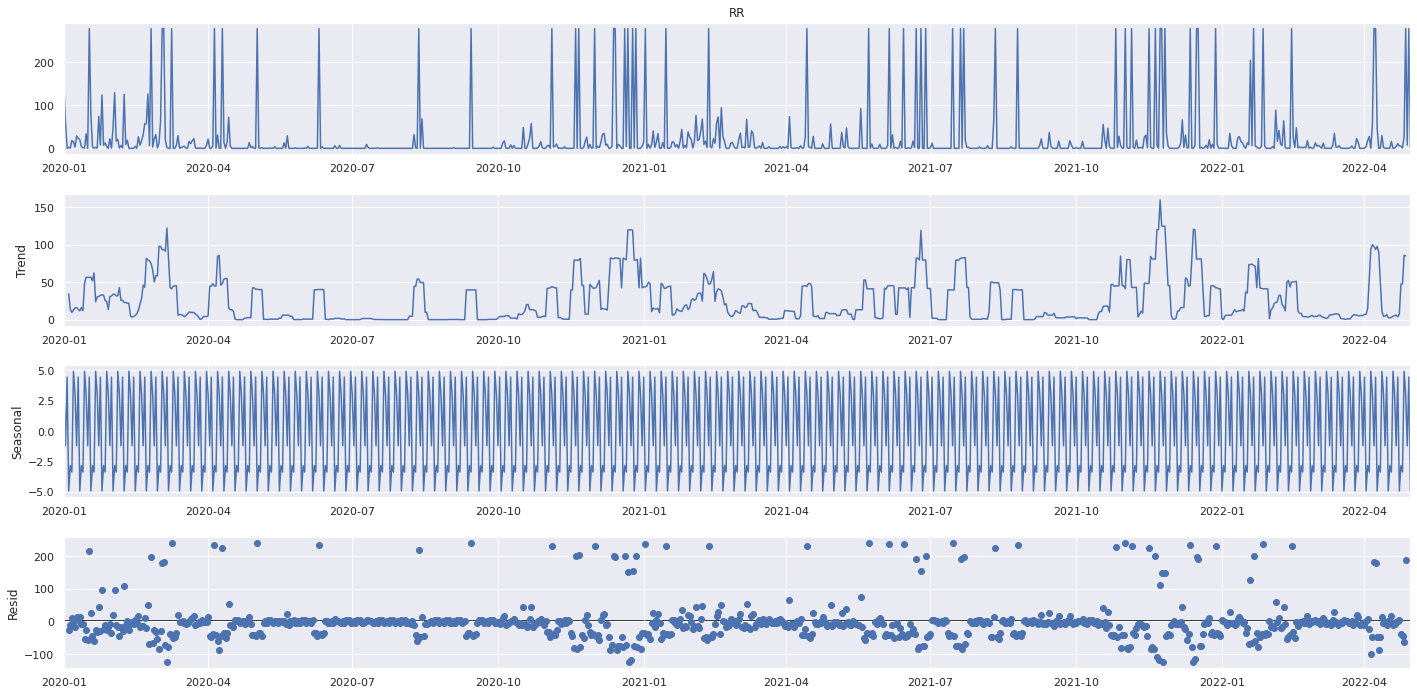

In [66]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_rain_20['RR'], model='additive')

fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20,10)

# Analisis Data

In [88]:
#uji augmented dickey fuller, menemukan mean standar deviasi
# data tahun 2020 keatas
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, window = 15, cutoff = 0.01):
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='cyan', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show
    
    print('Results of Dickey-Fuller Test: ')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistik','p-value',
                                             '#Lags used','Number of Observation Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical value (%s)' % key] = value
    
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely not-stationary.' % pvalue)
    
    print(dfoutput)

Results of DIckey-Fuller Test: 
p-value = 0.0000. The series is likely stationary.
Test Statistik                -18.909712
p-value                         0.000000
#Lags used                      1.000000
Number of Observation Used    849.000000
Critical value (1%)            -3.438076
Critical value (5%)            -2.864950
Critical value (10%)           -2.568586
dtype: float64


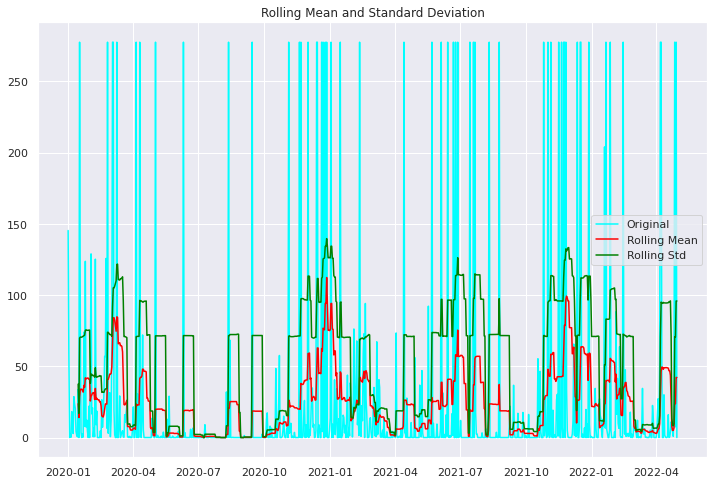

In [99]:
test_stationarity(df_rain_20['RR'])

### Lakukan differencing jika data tidak stasioner

### Estimasi

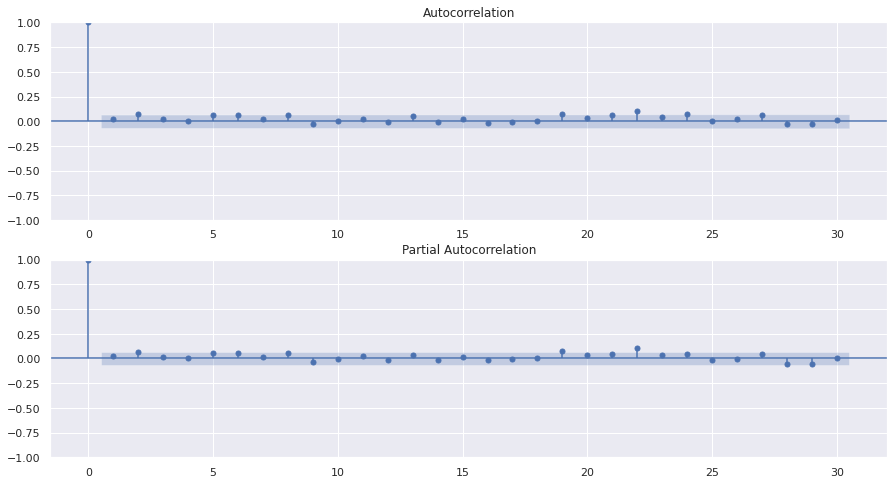

In [96]:
import statsmodels.api as sm
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_rain_20.RR, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_rain_20.RR, ax=ax2, method='ywm')

In [117]:
# we can see a recurring correlation exists in both ACF and PACF hece we should choose SARIMAX model which also deals with seasonality

#RULE : A model with no orders of differencing assumes that the original series is stationary (mean-reverting). A model with one order of differencing assumes that 
      #the original series has a constant average trend (e.g. a random walk or SES-type model, with or without growth). A model with two orders of total differencing assumes that 
      #the original series has a time-varying trend 

#Since our series has a contant average trend ( with growth ) we would take I = 1 and MA = 0 ( I-1 ).


sarimax_mod = sm.tsa.statespace.SARIMAX(df_rain_20.RR, trend='n', order=(14,1,0), freq=df_rain_20.index.inferred_freq).fit(disp=0)
print(sarimax_mod.summary())



                               SARIMAX Results                                
Dep. Variable:                     RR   No. Observations:                  851
Model:              SARIMAX(14, 1, 0)   Log Likelihood               -4816.005
Date:                Thu, 16 Jun 2022   AIC                           9662.010
Time:                        00:23:59   BIC                           9733.188
Sample:                    01-01-2020   HQIC                          9689.275
                         - 04-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9257      0.031    -30.232      0.000      -0.986      -0.866
ar.L2         -0.8119      0.041    -19.701      0.000      -0.893      -0.731
ar.L3         -0.7507      0.052    -14.548      0.0

# Forecast

In [105]:
today = datetime.date.today() - timedelta(days=1)
# dimulai dari 1 januari 20
start_index = '01-01-2020'
end_index = today.strftime("%d-%m-%Y")
end_index

'15-06-2022'

<AxesSubplot:xlabel='Tanggal'>

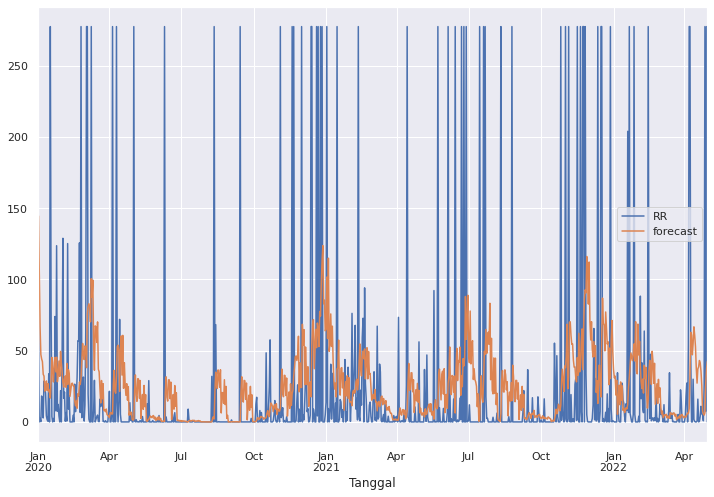

In [118]:
# menambahkan kolom prediksi pada dataframe
df_rain_20['forecast'] = sarimax_mod.predict(start= start_index,end = end_index,dynamic= False,infer_datetime_format=True) 
df_rain_20[start_index:][['RR', 'forecast']].plot(figsize=(12, 8))


In [119]:
future_predict = sarimax_mod.predict(start= datetime.date.today() ,end = datetime.date.today()+timedelta(days=7) ,dynamic= True,)

In [120]:
future_predict

2022-06-16    69.296456
2022-06-17    69.378119
2022-06-18    69.311352
2022-06-19    69.357610
2022-06-20    69.363450
2022-06-21    69.363112
2022-06-22    69.382429
2022-06-23    69.359352
Freq: D, Name: predicted_mean, dtype: float64

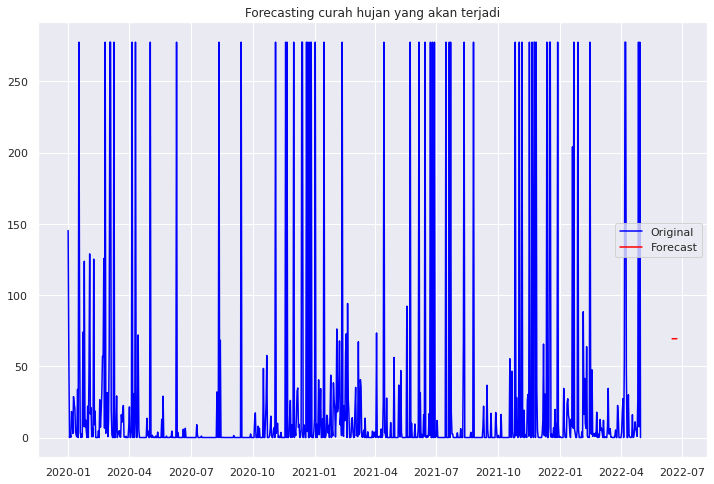

In [121]:
figg = plt.figure(figsize=(12, 8))
orig = plt.plot(df_rain_20['RR'], color='blue',label='Original')
fore = plt.plot(future_predict, color='red', label='Forecast')
plt.legend(loc='best')
plt.title('Forecasting curah hujan yang akan terjadi')
plt.show()

In [135]:
f_temp = pd.DataFrame()
f_temp['date'] = future_predict.index
f_temp['values'] = future_predict.values

In [136]:
f_temp

,date,values
0,2022-06-16,69.296456
1,2022-06-17,69.378119
2,2022-06-18,69.311352
3,2022-06-19,69.357610
4,2022-06-20,69.363450
5,2022-06-21,69.363112
6,2022-06-22,69.382429
7,2022-06-23,69.359352


In [137]:
f_temp.loc[-1] = [df_rain_20.index[-1],df_rain_20['RR'][-1]]

In [138]:
f_temp

,date,values
0,2022-06-16,69.296456
1,2022-06-17,69.378119
2,2022-06-18,69.311352
3,2022-06-19,69.357610
4,2022-06-20,69.363450
5,2022-06-21,69.363112
6,2022-06-22,69.382429
7,2022-06-23,69.359352
-1,2022-04-30,0.000000


In [139]:
f_temp.index = f_temp.index + 1
f_temp

,date,values
1,2022-06-16,69.296456
2,2022-06-17,69.378119
3,2022-06-18,69.311352
4,2022-06-19,69.357610
5,2022-06-20,69.363450
6,2022-06-21,69.363112
7,2022-06-22,69.382429
8,2022-06-23,69.359352
0,2022-04-30,0.000000


In [141]:
f_temp = f_temp.sort_index()
f_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9 entries, 0 to 8
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    9 non-null      datetime64[ns]
 1   values  9 non-null      float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 216.0 bytes


In [142]:
f_temp = f_temp.set_index('date')

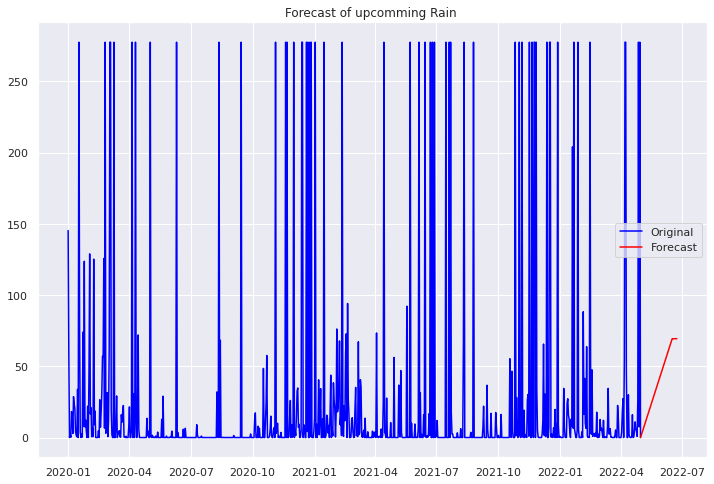

In [143]:
figg = plt.figure(figsize=(12, 8))
orig = plt.plot(df_rain_20['RR'], color='blue',label='Original')
fore = plt.plot(f_temp['values'], color='red', label='Forecast')
plt.legend(loc='best')
plt.title('Forecast of upcomming Rain ')
plt.show()

In [144]:
fcast = sarimax_mod.get_forecast(datetime.date.today()+timedelta(days=7))
fcast = fcast.conf_int()
fcast

,lower RR,upper RR
2022-05-01,-85.567821,188.131901
2022-05-02,-82.223279,192.230945
2022-05-03,-80.931202,195.457762
2022-05-04,-75.325921,201.897833
2022-05-05,-63.385054,214.574757
2022-05-06,-95.264534,184.982107
2022-05-07,-70.058445,212.824606
2022-05-08,-87.502898,197.006066
2022-05-09,-81.957098,205.869932
2022-05-10,-58.408960,230.144361


In [145]:
fcast = fcast.reset_index()
fcast.loc[-1] = [df_rain_20.index[-1],df_rain_20['RR'][-1],df_rain_20['RR'][-1]]
fcast.index = fcast.index + 1
fcast = fcast.sort_index()
fcast['index'] = pd.to_datetime(fcast['index'], format="%d-%b-%y")
fcast = fcast.set_index('index')
fcast

,lower RR,upper RR
index,,
2022-04-30,0.000000,0.000000
2022-05-01,-85.567821,188.131901
2022-05-02,-82.223279,192.230945
2022-05-03,-80.931202,195.457762
2022-05-04,-75.325921,201.897833
2022-05-05,-63.385054,214.574757
2022-05-06,-95.264534,184.982107
2022-05-07,-70.058445,212.824606
2022-05-08,-87.502898,197.006066


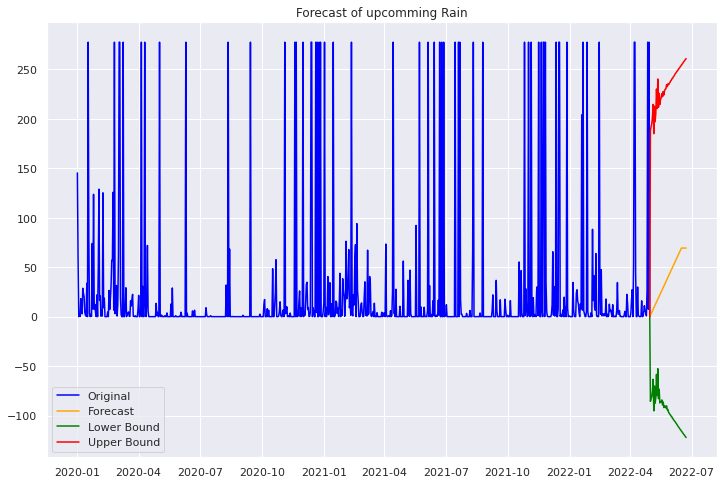

In [148]:
# predict lagi
figg = plt.figure(figsize=(12, 8))
orig = plt.plot(df_rain_20['RR'], color='blue',label='Original')
fore = plt.plot(f_temp['values'], color='orange', label='Forecast')
lower = plt.plot(fcast['lower RR'], color='green', label='Lower Bound')
upper = plt.plot(fcast['upper RR'], color='red', label='Upper Bound')
plt.legend(loc='best')
plt.title('Forecast of upcomming Rain')
plt.show()